# Projet 5 : Segmentez des clients d'un site e-commerce

Notebook d'essais de clustering.

*Olist* souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de **comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.

Vous devrez **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une **proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.


# Summary
 - <a href="#C1">Import and settings</a>
      - <a href="#C1.1">Import required items</a>
      - <a href="#C1.2">Settings</a>
 - <a href="#C2">Functions</a>
 - <a href="#C3">Explore sub-sets of data and test different clustering</a>
      - <a href="#C3.1">Transform the data by customer</a>
      - <a href="#C3.2">Proposal 1 : Prices, items number, review score and product categories</a>
          - <a href="#C3.2.1">Dimension reduction and projection</a>
          - <a href="#C3.2.2">Clustering</a>
      - <a href="#C3.3">Proposal 2 : Prices, items number, and review score</a>
          - <a href="#C3.3.1">Dimension reduction and projection</a>
          - <a href="#C3.3.2">Clustering</a>

# <a name="C1"> Import and settings
## <a name="C1.1"> Import required items

In [1]:
# Use code formatting tool
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import required librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn import (
    cluster,
    metrics,
    manifold,
    decomposition,
    ensemble,
)
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cut_tree

import datetime

import seaborn as sns

<IPython.core.display.Javascript object>

In [3]:
# Import data files in DataFrames
data_final = pd.read_csv("data_final.csv", index_col=0)

<IPython.core.display.Javascript object>

## <a name="C1.2"> Settings

In [4]:
# Set the results display
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = "{:,.4f}".format

<IPython.core.display.Javascript object>

In [5]:
# General settings
random = 42

<IPython.core.display.Javascript object>

# <a name="C2"> Functions

In [6]:
# Function to create a 3D projection plot
def display_3D(X_trans, x, y, z):
    """
    This function allows to create a 3 dimension plot in order to display a data projection
    done using a feature reduction method (PCA, kPCA, TSNE, lle...).

    Parameters
    ----------
    X_trans : 3 dimensions (minimum) array
    x : int, X_trans column to be used for the x axis
    y : int, X_trans column to be used for the y axis
    z : int, X_trans column to be used for the z axis

    Return
    ------
    3D plot

    """
    fig = plt.figure(figsize=[7, 7])
    ax = plt.axes(projection="3d")

    ax.plot(
        X_trans[:, x],
        X_trans[:, y],
        X_trans[:, z],
        ".",
    )
    plt.show

<IPython.core.display.Javascript object>

In [7]:
# Function to create a 3D projection plot
def display_clusters_3D(X_trans, my_cluster, x, y, z):
    """
    This function allows to create a 3 dimension plot in order to display a data projection
    done using a feature reduction method (PCA, kPCA, TSNE, lle...).
    In case there is a clustering, display the values using colors accordingly.

    Parameters
    ----------
    X_trans : 3 dimensions (minimum) array
    my_cluster : 1 dimension array representing the cluster for each individual
    x : int, X_trans column to be used for the x axis
    y : int, X_trans column to be used for the y axis
    z : int, X_trans column to be used for the z axis

    Return
    ------
    3D plot

    """
    fig = plt.figure(figsize=[7, 7])
    ax = plt.axes(projection="3d")

    # Set the colors
    color = cm.brg(np.linspace(0, 1, np.max(my_cluster) - np.min(my_cluster) + 1))

    for i in range(np.min(my_cluster), np.max(my_cluster) + 1):
        ax.plot(
            X_trans[my_cluster == i][:, x],
            X_trans[my_cluster == i][:, y],
            X_trans[my_cluster == i][:, z],
            ".",
            color=color[i],
            label=i,
        )
        ax.text(
            X_trans[my_cluster == i][:, x][0],
            X_trans[my_cluster == i][:, y][0],
            X_trans[my_cluster == i][:, z][0],
            str(i),
            color="black",
            size=16,
        )
        plt.legend(bbox_to_anchor=(1.2, 0.5), loc="right")
        plt.show

<IPython.core.display.Javascript object>

In [8]:
# Function to plot a dendrogram in order to figure out how the relevant number of clusters
def plot_dendrogram(Z, names, p):
    """
    This function allows to create a dendrogram plot in order to figure out how the relevant number of clusters for the tested dataset.

    Parameters
    ----------
    Z : hierarchical clustering method to be used
    names : dataframe, data to be tested
    p : int, maximum number of clusters to display in the plot

    Return
    ------
    plot

    """
    plt.figure(figsize=(10, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("distance")
    dendrogram(
        Z,
        truncate_mode="lastp",  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        show_leaf_counts=True,  # numbers in brackets are counts
        labels=names,
        orientation="top",
        leaf_font_size=8,
    )
    plt.show()

<IPython.core.display.Javascript object>

In [9]:
# Function to create a scree plot
def display_scree_plot(pca):
    """
    This function allows to create a plot with the inertia percentage of each component in a Principal Component Analysis.
    Inertia is shown individually for each component with an histogram, and cumulated with a line.

    Parameters
    ----------
    pca : fitted pca model

    Return
    ------
    plot

    """
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("inertia axis rank")
    plt.ylabel("inertia percentage")
    plt.title("Eigenvalue scree")
    plt.show(block=False)

<IPython.core.display.Javascript object>

# <a name="C3"> Explore sub-sets of data and test different clustering

In [10]:
# Explore data
print(len(data_final))
data_final.columns

111047


Index(['customer_unique_id', 'client_geolocation_lat',
       'client_geolocation_lng', 'client_geolocation_city',
       'client_geolocation_state', 'order_nb', 'order_id',
       'delivery_delay_days', 'items_nb', 'last_order_days', 'order_freq',
       'order_purchase_timestamp', 'total_items_nb', 'product_id',
       'product_description', 'product_photos_qty', 'price', 'freight_value',
       'payment_installments', 'seller_id', 'seller_geolocation_lat',
       'seller_geolocation_lng', 'seller_geolocation_city',
       'seller_geolocation_state', 'review_nb', 'review_score',
       'review_comment_lenght', 'cat_culture & tech', 'cat_daylife',
       'cat_fashion & gifts', 'cat_home & works', 'cat_other',
       'payment_boleto', 'payment_credit_card', 'payment_debit_card',
       'payment_voucher', 'voucher_share'],
      dtype='object')

<IPython.core.display.Javascript object>

## <a name="C3.1"> Transform the data by customer

In [11]:
# in order to consider data by unique customer, we need to calculate mean values by order, and by product.

# create a sub set by order in order to calculate mean values
order_features = [
    "customer_unique_id",
    "order_id",
    "review_score",
]

data_final_orders = (
    data_final[order_features]
    .drop_duplicates(subset="order_id")
    .pivot_table(index=["customer_unique_id"], aggfunc="mean")
    .reset_index()
)

# create a sub set by product in order to calculate mean values

product_features = [
    "customer_unique_id",
    "total_items_nb",
    "price",
    "cat_culture & tech",
    "cat_daylife",
    "cat_fashion & gifts",
    "cat_home & works",
]

data_final_products = (
    data_final[product_features]
    .pivot_table(index=["customer_unique_id"], aggfunc="mean")
    .reset_index()
)

<IPython.core.display.Javascript object>

In [12]:
data_final_orders.describe()

,review_score
count,"94,108.0000"
mean,4.0739
std,1.3660
min,0.0000
25%,4.0000
50%,5.0000
75%,5.0000
max,5.0000


<IPython.core.display.Javascript object>

In [13]:
data_final_products.describe()

,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works,price,total_items_nb
count,"94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,108.0000"
mean,0.2794,0.0998,0.2447,0.3718,126.5881,1.1800
std,0.4466,0.2979,0.4278,0.4810,191.4086,0.6200
min,0.0000,0.0000,0.0000,0.0000,0.8500,1.0000
25%,0.0000,0.0000,0.0000,0.0000,42.9000,1.0000
50%,0.0000,0.0000,0.0000,0.0000,79.0000,1.0000
75%,1.0000,0.0000,0.0000,1.0000,139.9000,1.0000
max,1.0000,1.0000,1.0000,1.0000,"6,735.0000",24.0000


<IPython.core.display.Javascript object>

In [14]:
# merge the sub sets in a single one with 1 line per unique customer
data_customer_pivot = pd.merge(
    data_final_orders, data_final_products, on="customer_unique_id", how="left"
)
data_customer_pivot = data_customer_pivot.dropna()
data_customer_pivot

,customer_unique_id,review_score,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works,price,total_items_nb
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0000,0.0000,0.0000,0.0000,1.0000,129.9000,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0000,0.0000,0.0000,1.0000,0.0000,18.9000,1
2,0000f46a3911fa3c0805444483337064,3.0000,1.0000,0.0000,0.0000,0.0000,69.0000,1
3,0000f6ccb0745a6a4b88665a16c9f078,4.0000,1.0000,0.0000,0.0000,0.0000,25.9900,1
4,0004aac84e0df4da2b147fca70cf8255,5.0000,1.0000,0.0000,0.0000,0.0000,180.0000,1
...,...,...,...,...,...,...,...,...
94103,fffcf5a5ff07b0908bd4e2dbc735a684,5.0000,0.0000,0.0000,1.0000,0.0000,785.0000,2
94104,fffea47cd6d3cc0a88bd621562a9d061,4.0000,0.0000,1.0000,0.0000,0.0000,64.8900,1
94105,ffff371b4d645b6ecea244b27531430a,5.0000,0.0000,0.0000,0.0000,1.0000,89.9000,1
94106,ffff5962728ec6157033ef9805bacc48,5.0000,0.0000,0.0000,1.0000,0.0000,115.0000,1


<IPython.core.display.Javascript object>

## <a name="C3.2"> Proposal 1 : Prices, items number, review score and product categories

In [15]:
# list the columns that needs to be scaled
col_std = [
    "price",
    "total_items_nb",
    "review_score",
]

# and the columns that we'll keep as they are
col_other = [
    "cat_culture & tech",
    "cat_daylife",
    "cat_fashion & gifts",
    "cat_home & works",
]

# keep only the selected columns
data_customer_final = data_customer_pivot[col_std + col_other]

<IPython.core.display.Javascript object>

In [16]:
data_customer_final.describe()

,price,total_items_nb,review_score,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works
count,"94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,108.0000","94,108.0000"
mean,126.5881,1.1800,4.0739,0.2794,0.0998,0.2447,0.3718
std,191.4086,0.6200,1.3660,0.4466,0.2979,0.4278,0.4810
min,0.8500,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,42.9000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000
50%,79.0000,1.0000,5.0000,0.0000,0.0000,0.0000,0.0000
75%,139.9000,1.0000,5.0000,1.0000,0.0000,0.0000,1.0000
max,"6,735.0000",24.0000,5.0000,1.0000,1.0000,1.0000,1.0000


<IPython.core.display.Javascript object>

In [17]:
# Scale the data using the Standard Scaler
X = data_customer_final
features = X.columns

scale = ColumnTransformer(
    transformers=[
        ("std", StandardScaler(), col_std),
        ("no_std", "passthrough", col_other),
    ]
)
X_std = scale.fit_transform(X)

print(X_std.shape)
print(X_std[0, :])

(94108, 7)
[ 0.0173031  -0.2903273   0.67799501  0.          0.          0.
  1.        ]


<IPython.core.display.Javascript object>

In [18]:
# Extract a random sample of data to be used in projections
s = int(len(X) / 4)
l = np.arange(len(X))
sample = np.random.choice(l, size=s, replace=False)
X_sample = X_std[sample, :]
X_sample.shape

(23527, 7)

<IPython.core.display.Javascript object>

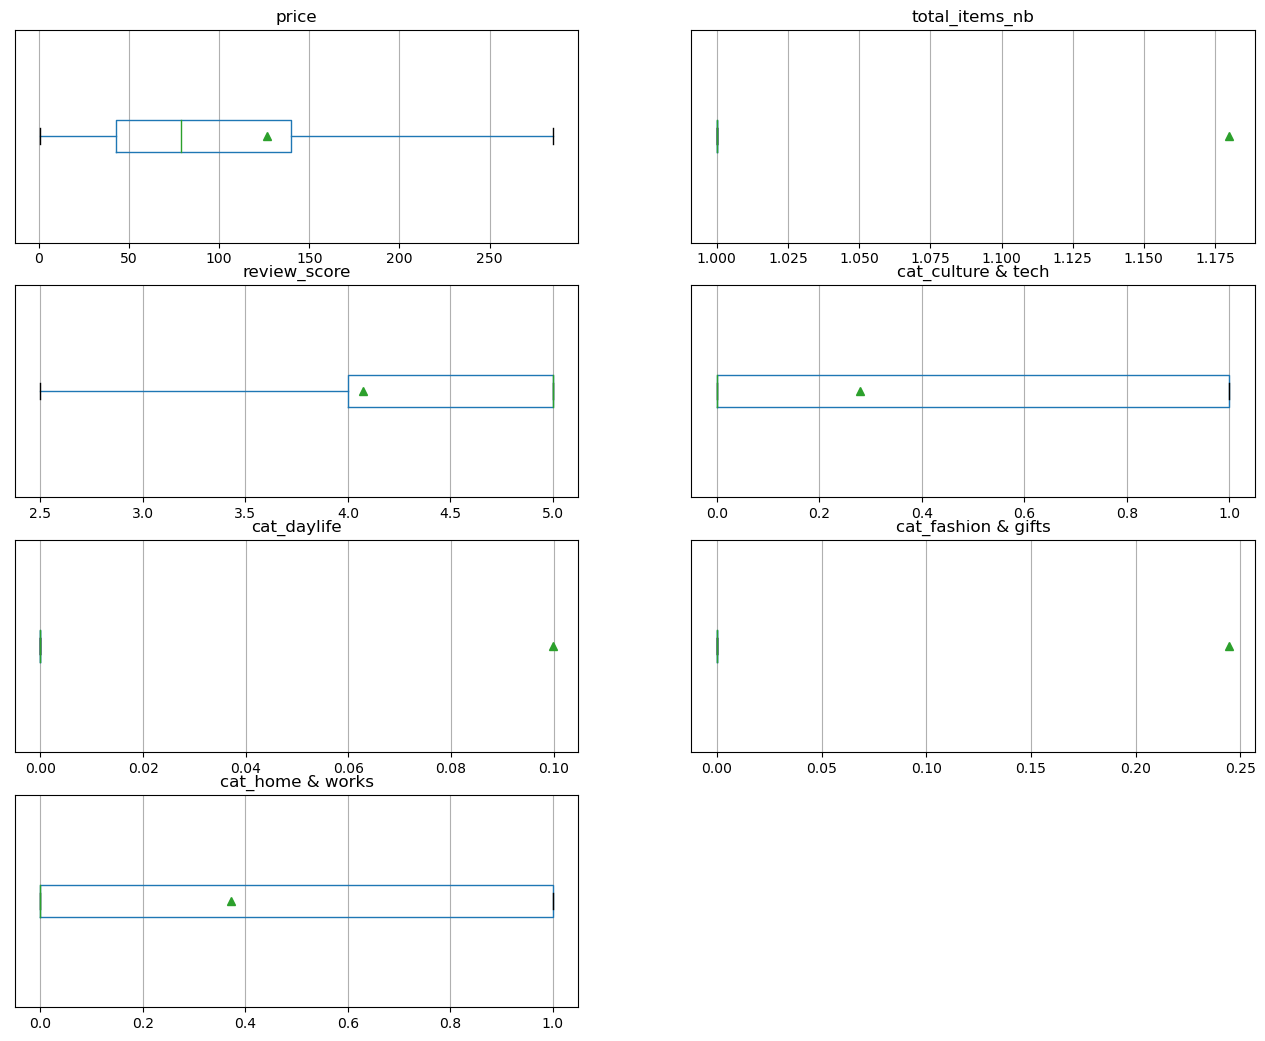

<IPython.core.display.Javascript object>

In [19]:
# Features distribution - boxplot
fig = plt.figure(figsize=(16, 16))

for i in range(len(features)):
    fig.add_subplot(5, 2, i + 1)
    feat = features[i]
    X.boxplot(column=feat, vert=False, showfliers=False, showmeans=True)
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.title(feat)
    i = +1

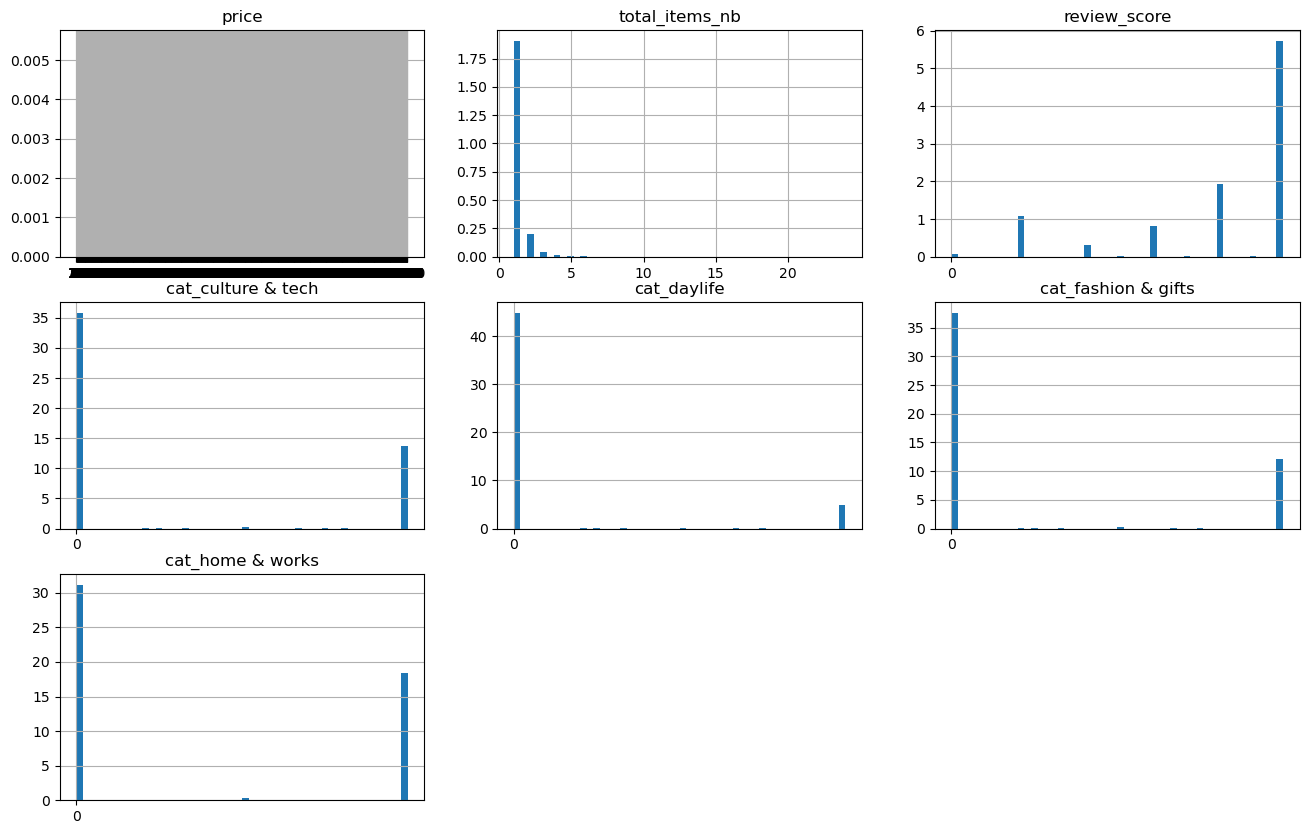

<IPython.core.display.Javascript object>

In [20]:
# Features distribution - histogram
fig = plt.figure(figsize=(16, 10))

for i in range(len(features)):
    fig.add_subplot(3, 3, i + 1)
    feat = features[i]
    X[feat].hist(density=True, bins=50)
    plt.xticks(np.arange(0, X[feat].max(), 5))
    plt.title(feat)
    i = +1

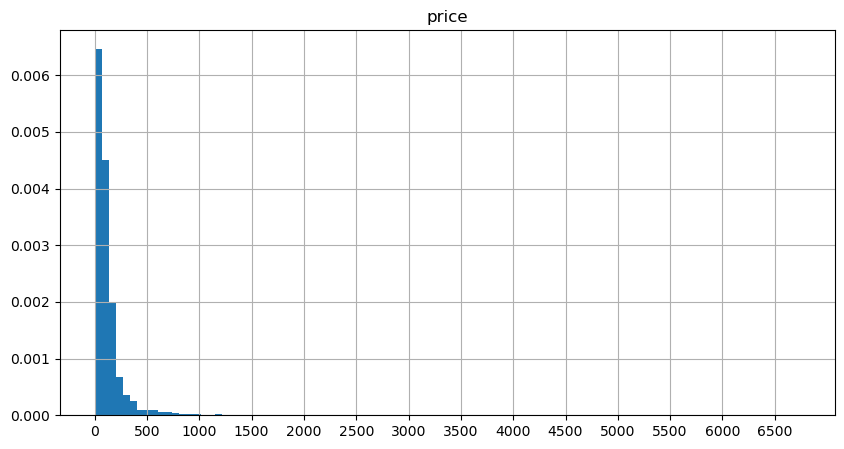

<Figure size 500x4000 with 0 Axes>

<IPython.core.display.Javascript object>

In [21]:
# Focus on prices
plt.figure(figsize=(10, 5))
X["price"].hist(density=True, bins=100)
plt.xticks(np.arange(0, X["price"].max() + 1, 500))
plt.title("price")
plt.figure(figsize=(5, 40))
plt.show()

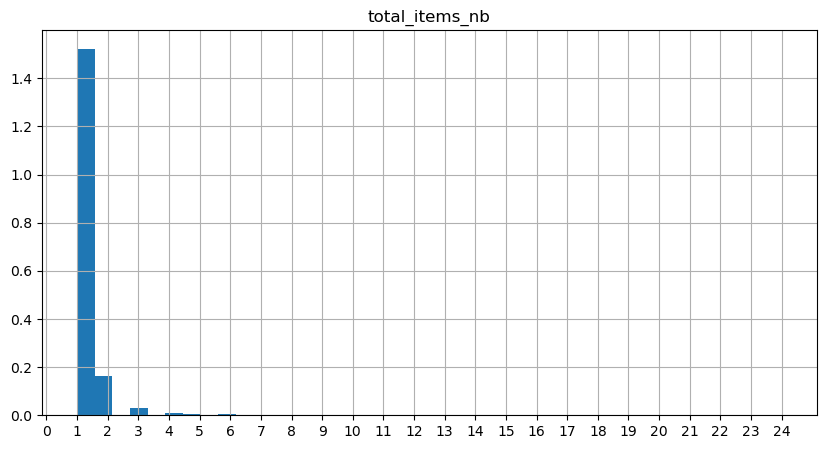

<IPython.core.display.Javascript object>

In [22]:
# Focus on total number of items
plt.figure(figsize=(10, 5))
X["total_items_nb"].hist(density=True, bins=40)
plt.xticks(np.arange(0, X["total_items_nb"].max() + 1, 1))
plt.title("total_items_nb")
plt.show()

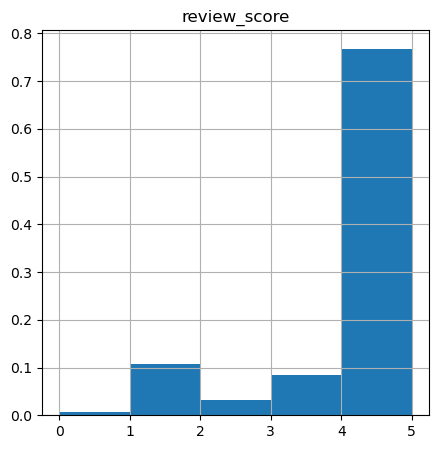

<IPython.core.display.Javascript object>

In [23]:
# Focus on total number of items
plt.figure(figsize=(5, 5))
X["review_score"].hist(density=True, bins=5)
plt.xticks(np.arange(0, X["review_score"].max() + 1, 1))
plt.title("review_score")
plt.show()

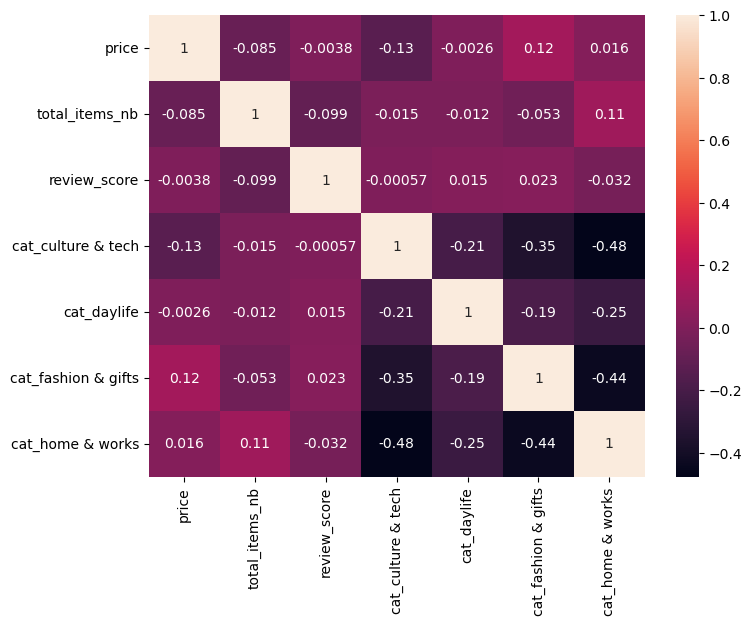

<IPython.core.display.Javascript object>

In [24]:
# Is there any correlations between those features?
corr_df = X.corr(method="spearman")
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

### <a name="C3.2.1"> Dimension reduction and projection

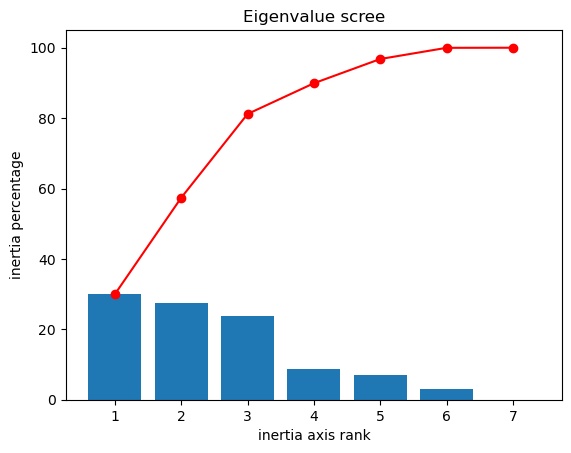

<IPython.core.display.Javascript object>

In [25]:
# PCA
# Components number - let's take the number of features for the test
n_comp = X_std.shape[1]

# Calculate Principal Components
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_std)

# Show the eigenvalue scree
display_scree_plot(pca)

In [26]:
# Set the relevant number of components (explain 90% of the variance)
c = 1
while pca.explained_variance_ratio_[0:c].cumsum()[-1] < 0.90:
    c += 1
print(c)

5


<IPython.core.display.Javascript object>

In [27]:
# Number of components for the PCA
n_comp = c

# Feature used to color the individual in the factorial planes
review = [
    round(data_customer_final.loc[review_id, "review_score"], 0)
    for review_id in X.index
]

# Calculate Principal Components
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_std)

# Correlation and projection
pcs = pca.components_
X_projected = pca.transform(X_std)
X_projected.shape

(94108, 5)

<IPython.core.display.Javascript object>

In [28]:
# Create a summary table for the components by features
pca_compo = pd.DataFrame()
pca_compo["features"] = features
pca_compo["F1"] = pca.components_.transpose()[:, 0]
pca_compo["F2"] = pca.components_.transpose()[:, 1]
pca_compo["F3"] = pca.components_.transpose()[:, 2]
pca_compo["F4"] = pca.components_.transpose()[:, 3]
pca_compo

,features,F1,F2,F3,F4
0,price,-0.3101,0.8594,0.4037,-0.0063
1,total_items_nb,0.7275,-0.0554,0.6800,0.0688
2,review_score,-0.6082,-0.5069,0.6107,-0.0100
3,cat_culture & tech,-0.0070,-0.0190,-0.0256,0.5245
4,cat_daylife,-0.0072,-0.0055,-0.0062,0.0371
5,cat_fashion & gifts,-0.0396,0.0305,0.0002,0.2480
6,cat_home & works,0.0547,-0.0083,0.0303,-0.8107


<IPython.core.display.Javascript object>

In [29]:
# Let's look at the features that has a strong correlation with each component
for col in pca_compo.columns[1:]:
    print(col, ":")
    mask = pca_compo[col].abs() > 0.5
    print(pca_compo.loc[mask, ["features", col]])
    print(50 * "-")

F1 :
         features      F1
1  total_items_nb  0.7275
2    review_score -0.6082
--------------------------------------------------
F2 :
       features      F2
0         price  0.8594
2  review_score -0.5069
--------------------------------------------------
F3 :
         features     F3
1  total_items_nb 0.6800
2    review_score 0.6107
--------------------------------------------------
F4 :
             features      F4
3  cat_culture & tech  0.5245
6    cat_home & works -0.8107
--------------------------------------------------


<IPython.core.display.Javascript object>

Looking at F1 and F3, correlation with review score is not really relevant.

(23527, 5)

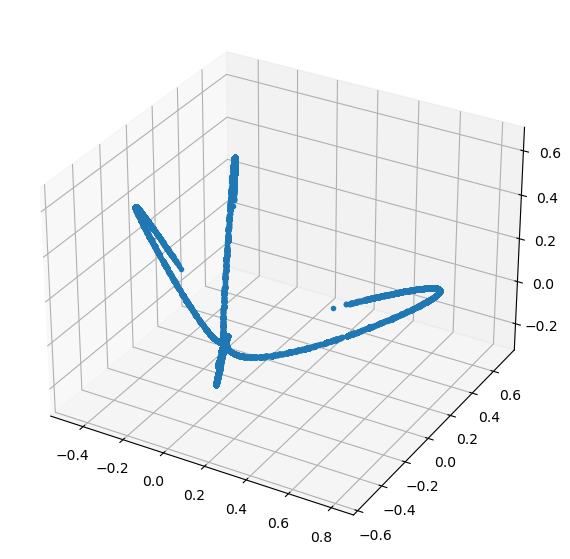

<IPython.core.display.Javascript object>

In [30]:
# Let's try to visually project the data thanks to a kernel PCA
# Calculate kernel PCA on the data sample
kpca = decomposition.KernelPCA(
    n_components=n_comp,  # keep the same numnber of components as the standard PCA
    kernel="rbf",
    gamma=10,
    random_state=random,
)
X_kpca = kpca.fit_transform(X_sample)

# Project the values in a 3D plot
display_3D(X_kpca, 0, 1, 2)

X_kpca.shape

### <a name="C3.2.2"> Clustering

Use different methods to figure out what is the most relevant number of clusters.

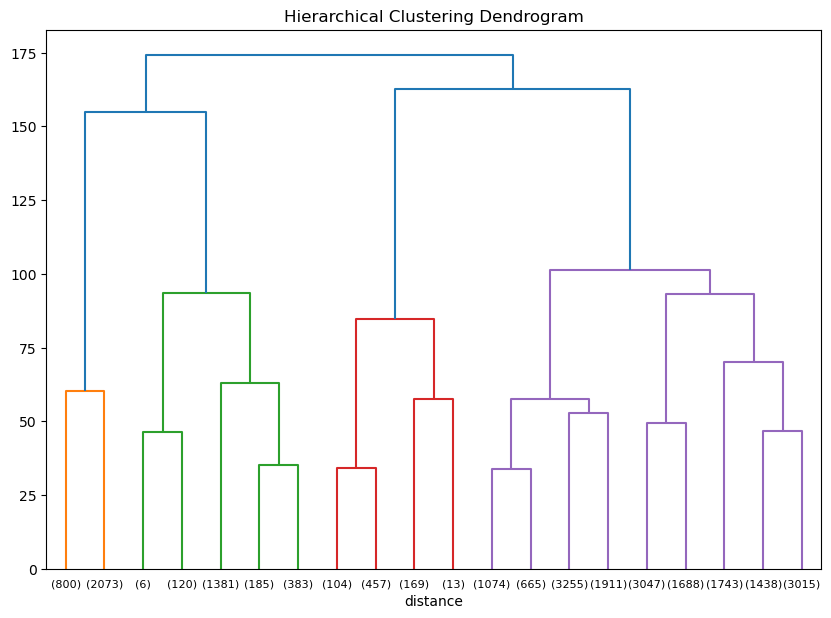

<IPython.core.display.Javascript object>

In [31]:
# Hierarchical Clustering
Z = linkage(X_sample, "ward")

# Display dendrogram
plot_dendrogram(Z, X.iloc[sample, :].index, 20)

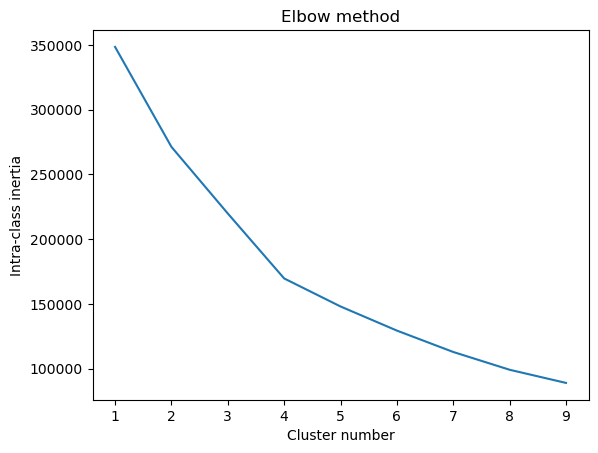

<IPython.core.display.Javascript object>

In [32]:
# Elbow method to figure out how many clusters we should have
tab = []
for i in range(1, 10):
    kmeans_elbow = cluster.KMeans(n_clusters=i, n_init=15, random_state=random)
    kmeans_elbow.fit(X_std)
    # Inertia : It is the sum of the squared distances of the samples to their nearest cluster centre.
    tab.append(kmeans_elbow.inertia_)
plt.plot(range(1, 10), tab)
plt.title("Elbow method")
plt.xlabel("Cluster number")
plt.ylabel("Intra-class inertia")
plt.show()

In [33]:
# Method to test different clustering solutions and assess the stability of each one of them
# Clustering method : Kmeans
# Number of clusters to be tested
params = [3, 4, 5, 6, 7, 8]
# Number of data samples to be used to cross test the clusters
n = 4
# Sample size
k = int(len(X_std) / n)

# Create a DataFrame to gather results
summary_kmeans = pd.DataFrame(
    columns=["clusters", "k", "silhouette", "calinski_harabasz", "davies_bouldin"]
)

# Test each cluster number
for par in params:
    kmeans_cv = cluster.KMeans(n_clusters=par, n_init=15, random_state=random)
    a = X_std
    # Test different data sample
    for i in range(n):
        if i != n:
            l = np.arange(len(a))
            rand = np.random.choice(l, size=k, replace=False)
            sub = a[rand, :]
            a = a[~rand, :]
        else:
            sub = a

        # fit the clustering and get their labels
        clustering = kmeans_cv.fit(sub).labels_

        # Calculate metrics to assess clustering quality
        sil = metrics.silhouette_score(sub, clustering)
        cal = metrics.calinski_harabasz_score(sub, clustering)
        dav = metrics.davies_bouldin_score(sub, clustering)

        # set the row where to add the data in the DataFrame
        r = len(summary_kmeans) + 1

        # Add the data in the DataFrame
        summary_kmeans.loc[r] = [par, i, sil, cal, dav]

        i += 1

# Display the table
summary_kmeans

,clusters,k,silhouette,calinski_harabasz,davies_bouldin
1,3.0000,0.0000,0.4024,"6,910.3543",1.1271
2,3.0000,1.0000,0.3997,"6,854.3326",1.1477
3,3.0000,2.0000,0.3997,"6,854.3346",1.1474
4,3.0000,3.0000,0.3997,"6,854.3326",1.1477
5,4.0000,0.0000,0.4042,"8,241.4257",0.9378
6,4.0000,1.0000,0.4080,"8,381.0614",0.9463
7,4.0000,2.0000,0.4499,"8,146.8427",0.8687
8,4.0000,3.0000,0.4080,"8,381.0628",0.9462
9,5.0000,0.0000,0.3102,"7,883.1438",1.0871
10,5.0000,1.0000,0.3098,"7,967.5956",1.0919


<IPython.core.display.Javascript object>

In [34]:
# Display the mean values of the metrics for each cluster number
kmeans_pivot = summary_kmeans.pivot_table(
    values=["silhouette", "calinski_harabasz", "davies_bouldin"],
    index=["clusters"],
    aggfunc="mean",
)

# Set the best cluster number according to the best metrics
clusters_nb = int(
    round(
        (
            kmeans_pivot["silhouette"].idxmax()
            * 2  # more importance is given to the silhouette score
            + kmeans_pivot["davies_bouldin"].idxmin() / 2
            + kmeans_pivot["calinski_harabasz"].idxmax() / 2
        )
        / 3,
        0,
    )
)
print(clusters_nb)

kmeans_pivot

8


,calinski_harabasz,davies_bouldin,silhouette
clusters,,,
3.0000,"6,868.3385",1.1425,0.4004
4.0000,"8,287.5982",0.9248,0.4175
5.0000,"7,946.1550",1.0893,0.3098
6.0000,"7,999.5623",1.0217,0.3771
7.0000,"8,351.1699",0.9626,0.4202
8.0000,"8,310.8745",0.9220,0.4284


<IPython.core.display.Javascript object>

In [35]:
# Method to test different clustering solutions and assess the stability of each one of them
# Clustering method : Ward
# Number of clusters to be tested
params = [3, 4, 5, 6, 7, 8]
# Number of data samples to be used to cross test the clusters
n = 4
# Sample size
k = int(len(X_std) / n)

# Create a DataFrame to gather results
summary_ward = pd.DataFrame(
    columns=["clusters", "k", "silhouette", "calinski_harabasz", "davies_bouldin"]
)

# Test each cluster number
for par in params:
    ward_cv = cluster.AgglomerativeClustering(n_clusters=par, linkage="ward")
    a = X_std
    # Test different data sample
    for i in range(n):
        if i != n:
            l = np.arange(len(a))
            rand = np.random.choice(l, size=k, replace=False)
            sub = a[rand, :]
            a = a[~rand, :]
        else:
            sub = a

        # fit the clustering and get their labels
        clustering = ward_cv.fit(sub).labels_

        # Calculate metrics to assess clustering quality
        sil = metrics.silhouette_score(sub, clustering)
        cal = metrics.calinski_harabasz_score(sub, clustering)
        dav = metrics.davies_bouldin_score(sub, clustering)

        # set the row where to add the data in the DataFrame
        r = len(summary_ward) + 1

        # Add the data in the DataFrame
        summary_ward.loc[r] = [par, i, sil, cal, dav]

        i += 1

# Display the table
summary_ward

,clusters,k,silhouette,calinski_harabasz,davies_bouldin
1,3.0000,0.0000,0.4004,"5,806.1659",1.3811
2,3.0000,1.0000,0.3974,"5,377.6451",1.1019
3,3.0000,2.0000,0.3974,"5,377.6451",1.1019
4,3.0000,3.0000,0.3974,"5,377.6451",1.1019
5,4.0000,0.0000,0.4211,"6,714.0744",1.0018
6,4.0000,1.0000,0.4074,"6,548.1401",0.9635
7,4.0000,2.0000,0.4074,"6,548.1401",0.9635
8,4.0000,3.0000,0.4074,"6,548.1401",0.9635
9,5.0000,0.0000,0.2861,"6,138.0808",1.1522
10,5.0000,1.0000,0.2755,"6,741.0089",1.1400


<IPython.core.display.Javascript object>

Let's now look at the clusters using the relevant number of clusters.

Silhouette Coefficient: 0.434
Calinski Harabasz Score: 33822.970
Davies Bouldin Score: 0.939
--------------------------------------------------
7    24342
2    24191
4    19454
1    12547
6     8350
0     3441
3     1182
5      601
Name: cluster, dtype: int64


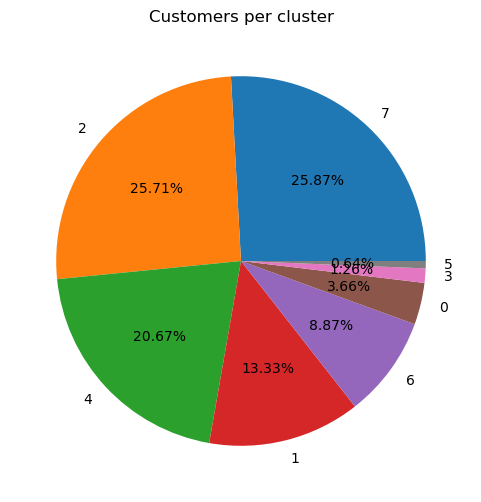

,population,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works,price,review_score,total_items_nb
7,24342,0.0000,0.2919,0.6985,0.0000,106.6371,4.6030,1.0000
2,24191,0.0000,0.0000,0.0000,1.0000,97.5836,4.5637,1.0000
4,19454,1.0000,0.0000,0.0000,0.0000,82.7312,4.5863,1.0000
1,12547,0.2795,0.0943,0.2353,0.3878,107.1403,1.1625,1.1617
6,8350,0.2511,0.0780,0.1755,0.4909,83.5994,4.3306,2.1933
0,3441,0.2226,0.1003,0.3806,0.2735,629.9781,4.2260,1.0352
3,1182,0.2091,0.0711,0.1329,0.5820,79.6136,3.4271,5.0660
5,601,0.3644,0.0433,0.2313,0.3428,"1,735.2549",3.9567,1.0316


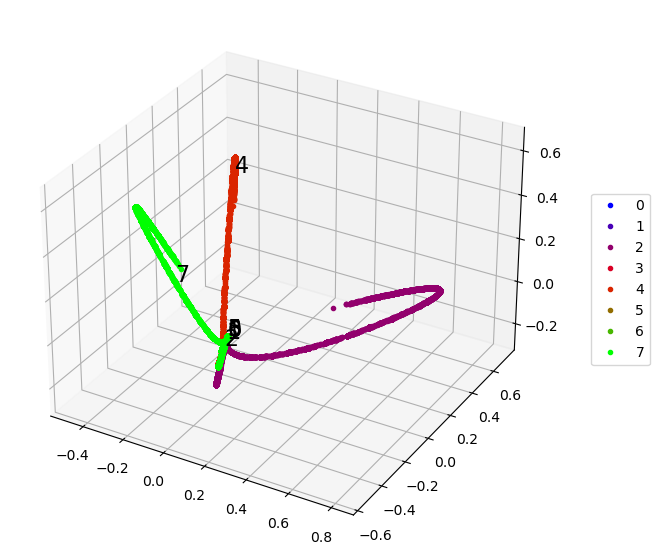

<IPython.core.display.Javascript object>

In [36]:
# Use the kmeans clustering method with the defined number of clusters
kmeans_test = cluster.KMeans(n_clusters=clusters_nb, n_init=15, random_state=random)

labels = kmeans_test.fit(X_std).labels_
X_trans = X_kpca

# add the clusters to the orignial dataset
X.loc[:, "cluster"] = labels

# Evaluate the clusters
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_std, labels))
print("Calinski Harabasz Score: %0.3f" % metrics.calinski_harabasz_score(X_std, labels))
print("Davies Bouldin Score: %0.3f" % metrics.davies_bouldin_score(X_std, labels))
print(50 * "-")

# Count the number of customer per cluster
a = X["cluster"].value_counts()
print(a)

# display the customers split by cluster
plt.figure(figsize=(6, 6))
plt.title("Customers per cluster")
plt.pie(a, labels=a.index, autopct="%.2f%%")
plt.show()

# Project the values
display_clusters_3D(X_trans, X.iloc[sample, X.columns.get_loc("cluster")], 0, 1, 2)

# Calculate and display mean values for each cluster
b = pd.DataFrame(a)
b.rename(
    {
        "cluster": "population",
    },
    axis=1,
    inplace=True,
)

c = X.pivot_table(index=["cluster"])
data_clusters = pd.merge(b, c, left_index=True, right_index=True)
data_clusters

Clusters description :
- 7 : happy customers who has bought 1 product, mostly **fashion & gifts products**
- 2 : happy customers who has bought 1 product, only **home & works products**
- 4 : happy customers who has bought 1 product, only **culture & tech products**
- 1 : **unhappy** customers
- 6 : happy customers who has bought **2 products** in average
- 0 : happy customers who has bought 1 **expensive** product
- 3 : **loyal customers**, 5 products in average
- 5 : customers who have bought 1 **very expensive** product

Cluster 2 :


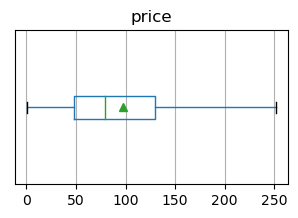

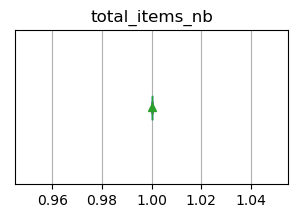

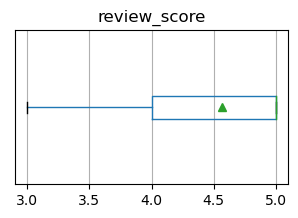

--------------------------------------------------
Cluster 7 :


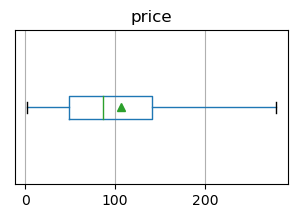

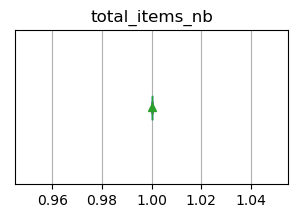

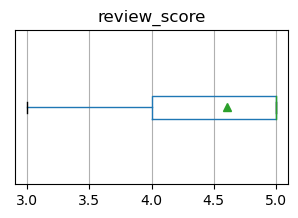

--------------------------------------------------
Cluster 4 :


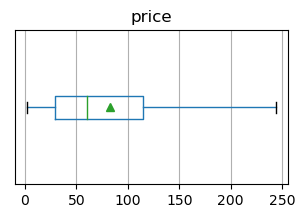

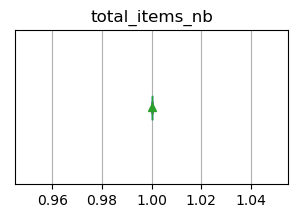

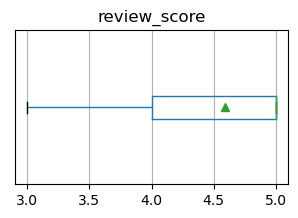

--------------------------------------------------
Cluster 1 :


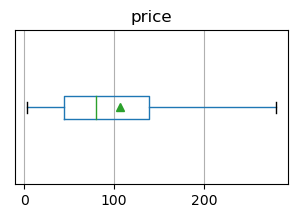

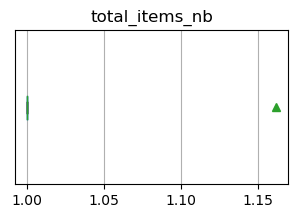

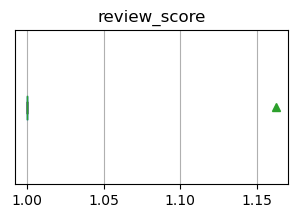

--------------------------------------------------
Cluster 3 :


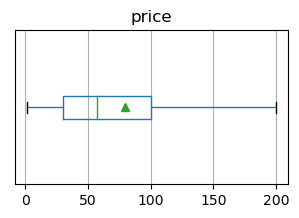

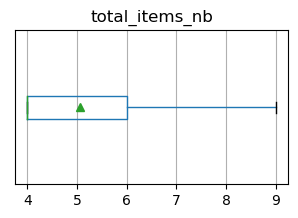

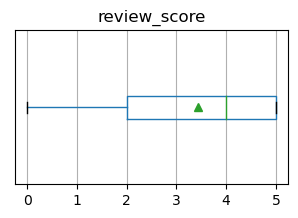

--------------------------------------------------
Cluster 6 :


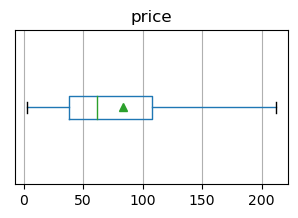

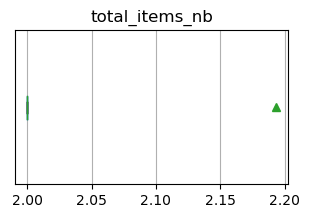

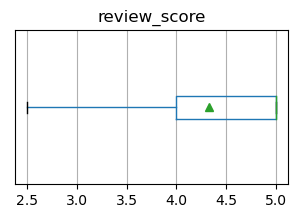

--------------------------------------------------
Cluster 0 :


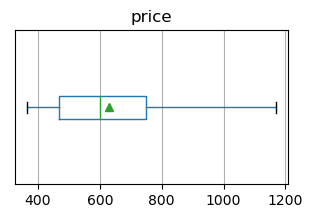

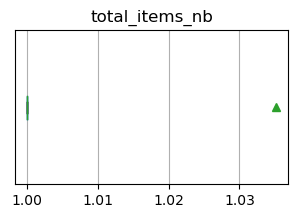

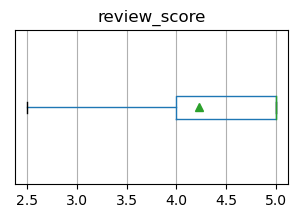

--------------------------------------------------
Cluster 5 :


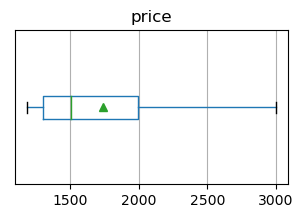

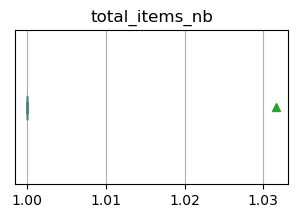

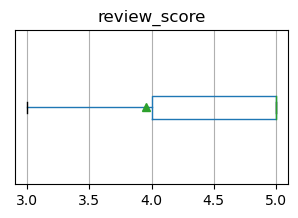

--------------------------------------------------


<IPython.core.display.Javascript object>

In [37]:
# Features distribution by cluster - boxplot
for c in X["cluster"].unique():
    print("Cluster", c, ":")
    for i in range(len(col_std)):
        fig = plt.figure(figsize=(12, 2))
        fig.add_subplot(1, len(col_std), i + 1)
        feat = col_std[i]
        X[X["cluster"] == c].boxplot(
            column=feat, vert=False, showfliers=False, showmeans=True
        )
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        plt.title(feat)
        i = +1
        plt.show()
    print(50 * "-")

## <a name="C3.3"> Proposal 2 : Prices, items number, and review score

In [38]:
data_customer_pivot.columns

Index(['customer_unique_id', 'review_score', 'cat_culture & tech',
       'cat_daylife', 'cat_fashion & gifts', 'cat_home & works', 'price',
       'total_items_nb'],
      dtype='object')

<IPython.core.display.Javascript object>

In [39]:
# In this test, we remove the product categories
data_customer_final = data_customer_pivot[col_std]

<IPython.core.display.Javascript object>

In [40]:
# Scale the data using the Standard Scaler
X = data_customer_final
features = X.columns

scale = ColumnTransformer(
    transformers=[
        ("std", StandardScaler(), col_std),
    ]
)
X_std = scale.fit_transform(X)

print(X_std.shape)
print(X_std[0, :])

(94108, 3)
[ 0.0173031  -0.2903273   0.67799501]


<IPython.core.display.Javascript object>

In [41]:
# Extract a random sample of data to be used in projections
s = int(len(X) / 4)
l = np.arange(len(X))
sample = np.random.choice(l, size=s, replace=False)
X_sample = X_std[sample, :]
X_sample.shape

(23527, 3)

<IPython.core.display.Javascript object>

### <a name="C3.3.1"> Dimension reduction and projection

(23527, 3)

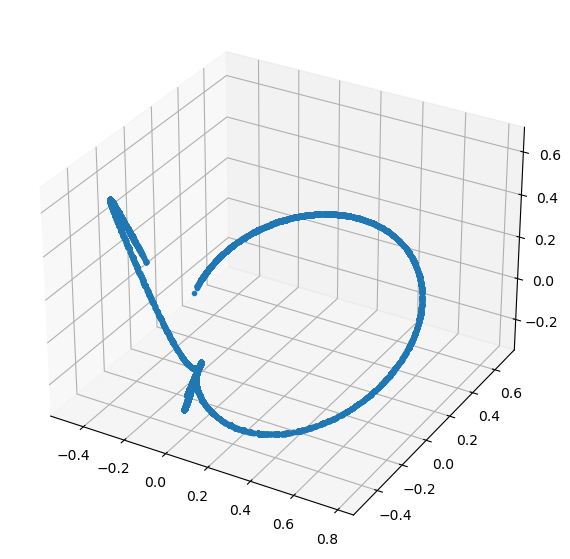

<IPython.core.display.Javascript object>

In [42]:
# Let's try to visually project the data thanks to a kernel PCA
# Calculate kernel PCA on the data sample
kpca = decomposition.KernelPCA(
    n_components=3,  # 3 components as there are 3 features
    kernel="rbf",
    gamma=10,
    random_state=random,
)
X_kpca = kpca.fit_transform(X_sample)

# Project the values in a 3D plot
display_3D(X_kpca, 1, 0, 2)

X_kpca.shape

### <a name="C3.3.2"> Clustering

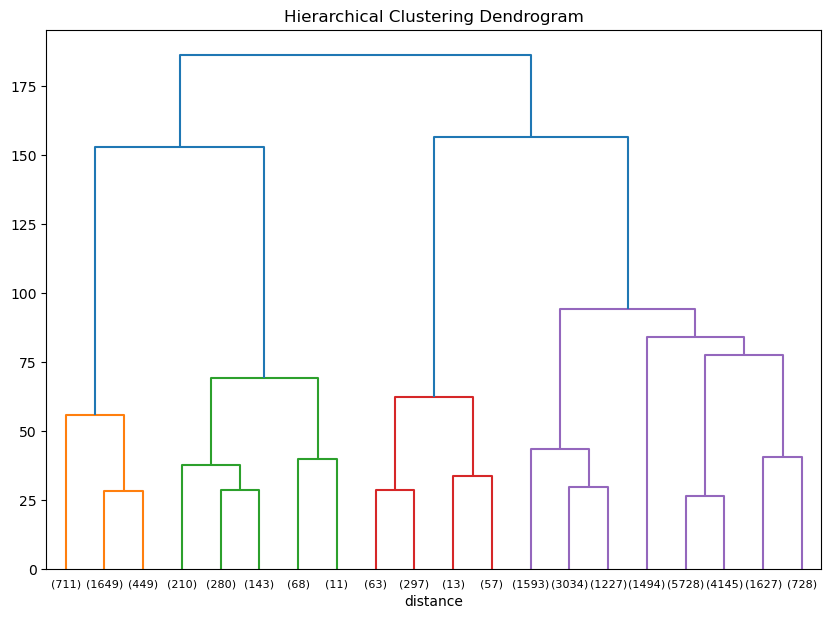

<IPython.core.display.Javascript object>

In [43]:
# Hierarchical Clustering
Z = linkage(X_sample, "ward")

# Display dendrogram
plot_dendrogram(Z, X.iloc[sample, :].index, 20)

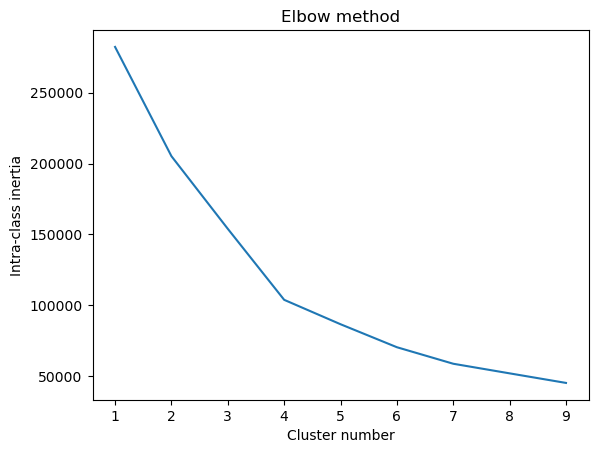

<IPython.core.display.Javascript object>

In [44]:
# Elbow method to figure out how many clusters we should have
tab = []
for i in range(1, 10):
    kmeans_elbow = cluster.KMeans(n_clusters=i, n_init=15, random_state=random)
    kmeans_elbow.fit(X_std)
    # Inertia : It is the sum of the squared distances of the samples to their nearest cluster centre.
    tab.append(kmeans_elbow.inertia_)
plt.plot(range(1, 10), tab)
plt.title("Elbow method")
plt.xlabel("Cluster number")
plt.ylabel("Intra-class inertia")
plt.show()

In [45]:
# Method to test different clustering solutions and assess the stability of each one of them
# Clustering method : Kmeans
# Number of clusters to be tested
params = [3, 4, 5, 6, 7, 8]
# Number of data samples to be used to cross test the clusters
n = 4
# Sample size
k = int(len(X_std) / n)

# Create a DataFrame to gather results
summary_kmeans = pd.DataFrame(
    columns=["clusters", "k", "silhouette", "calinski_harabasz", "davies_bouldin"]
)

# Test each cluster number
for par in params:
    kmeans_cv = cluster.KMeans(n_clusters=par, n_init=15, random_state=random)
    a = X_std
    # Test different data sample
    for i in range(n):
        if i != n:
            l = np.arange(len(a))
            rand = np.random.choice(l, size=k, replace=False)
            sub = a[rand, :]
            a = a[~rand, :]
        else:
            sub = a

        # fit the clustering and get their labels
        clustering = kmeans_cv.fit(sub).labels_

        # Calculate metrics to assess clustering quality
        sil = metrics.silhouette_score(sub, clustering)
        cal = metrics.calinski_harabasz_score(sub, clustering)
        dav = metrics.davies_bouldin_score(sub, clustering)

        # set the row where to add the data in the DataFrame
        r = len(summary_kmeans) + 1

        # Add the data in the DataFrame
        summary_kmeans.loc[r] = [par, i, sil, cal, dav]

        i += 1

# Display the table
summary_kmeans

,clusters,k,silhouette,calinski_harabasz,davies_bouldin
1,3.0000,0.0000,0.5984,"9,248.5922",0.8964
2,3.0000,1.0000,0.5516,"9,527.9238",0.8818
3,3.0000,2.0000,0.6012,"9,518.0843",0.8794
4,3.0000,3.0000,0.5516,"9,527.9238",0.8818
5,4.0000,0.0000,0.5756,"13,962.9277",0.6964
6,4.0000,1.0000,0.5786,"13,724.6035",0.6929
7,4.0000,2.0000,0.5786,"13,724.6037",0.6929
8,4.0000,3.0000,0.5786,"13,724.6037",0.6929
9,5.0000,0.0000,0.5930,"13,366.3722",0.6988
10,5.0000,1.0000,0.5943,"13,675.5606",0.6892


<IPython.core.display.Javascript object>

In [46]:
# Display the mean values of the metrics for each cluster number
kmeans_pivot = summary_kmeans.pivot_table(
    values=["silhouette", "calinski_harabasz", "davies_bouldin"],
    index=["clusters"],
    aggfunc="mean",
)

# Set the best cluster number according to the best metrics
clusters_nb = int(
    round(
        (
            kmeans_pivot["silhouette"].idxmax()
            * 2  # more importance is given to the silhouette score
            + kmeans_pivot["davies_bouldin"].idxmin() / 2
            + kmeans_pivot["calinski_harabasz"].idxmax() / 2
        )
        / 3,
        0,
    )
)
print(clusters_nb)

kmeans_pivot

7


,calinski_harabasz,davies_bouldin,silhouette
clusters,,,
3.0000,"9,455.6310",0.8849,0.5757
4.0000,"13,784.1846",0.6938,0.5778
5.0000,"13,508.9386",0.6909,0.5939
6.0000,"14,150.3346",0.6852,0.5985
7.0000,"14,453.2544",0.6938,0.5419
8.0000,"16,444.1900",0.6814,0.5428


<IPython.core.display.Javascript object>

C:\Users\bruno\AppData\Local\Temp\ipykernel_8468\676182082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, "cluster"] = labels


Silhouette Coefficient: 0.537
Calinski Harabasz Score: 59880.334
Davies Bouldin Score: 0.700
--------------------------------------------------
0    45725
6    21759
1    12548
2     8347
4     3929
5     1182
3      618
Name: cluster, dtype: int64


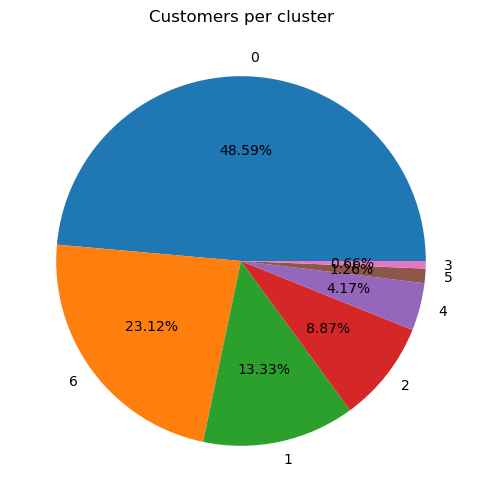

,population,price,review_score,total_items_nb
0,45725,95.2184,5.0000,1.0000
6,21759,93.1189,3.7072,1.0000
1,12548,107.1939,1.1624,1.1616
2,8347,83.4752,4.3304,2.1934
4,3929,594.1065,4.2954,1.0318
5,1182,79.6136,3.4271,5.0660
3,618,"1,719.6259",3.9434,1.0307


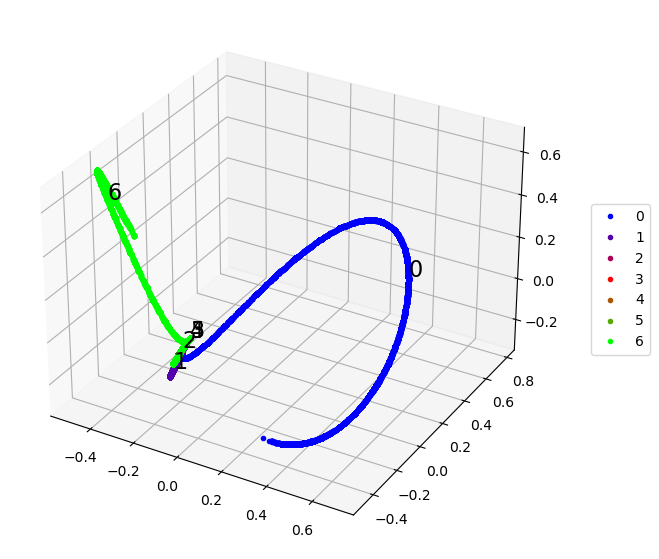

<IPython.core.display.Javascript object>

In [47]:
# Use the kmeans clustering method with the defined number of clusters
kmeans_test = cluster.KMeans(n_clusters=clusters_nb, n_init=15, random_state=random)

labels = kmeans_test.fit(X_std).labels_
X_trans = X_kpca

# add the clusters to the orignial dataset
X.loc[:, "cluster"] = labels

# Evaluate the clusters
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_std, labels))
print("Calinski Harabasz Score: %0.3f" % metrics.calinski_harabasz_score(X_std, labels))
print("Davies Bouldin Score: %0.3f" % metrics.davies_bouldin_score(X_std, labels))
print(50 * "-")

# Count the number of customer per cluster
a = X["cluster"].value_counts()
print(a)

# display the customers split by cluster
plt.figure(figsize=(6, 6))
plt.title("Customers per cluster")
plt.pie(
    a,
    labels=a.index,
    autopct="%.2f%%",
)
plt.show()

# Project the values
display_clusters_3D(X_trans, X.iloc[sample, X.columns.get_loc("cluster")], 0, 1, 2)

# Calculate and display mean values for each cluster
b = pd.DataFrame(a)
b.rename(
    {
        "cluster": "population",
    },
    axis=1,
    inplace=True,
)

c = X.pivot_table(index=["cluster"])
data_clusters = pd.merge(b, c, left_index=True, right_index=True)
data_clusters

Clusters description :
- 2 : happy customers who has bought **1 product**
- 1 : **unhappy** customers
- 0 : happy customers who has bought **2 products** in average
- 3 : happy customers who has bought 1 **expensive** product
- 5 : **loyal customers**, 5 products in average
- 4 : customers who have bought 1 **very expensive** product

Cluster 0 :


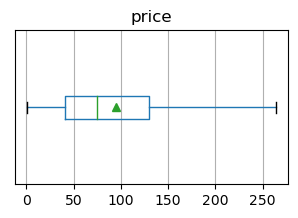

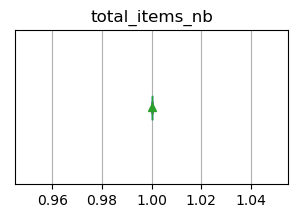

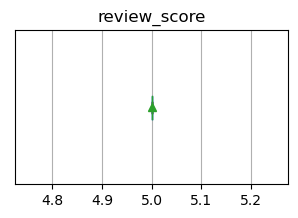

--------------------------------------------------
Cluster 6 :


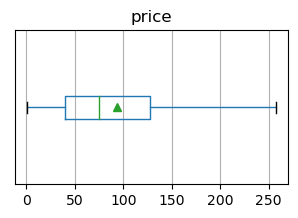

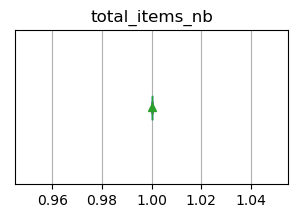

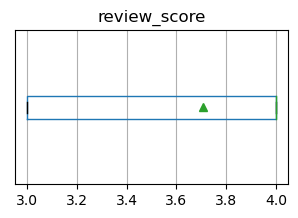

--------------------------------------------------
Cluster 1 :


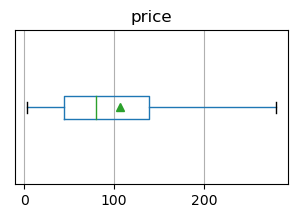

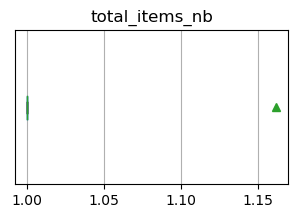

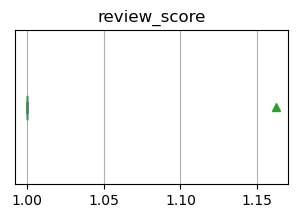

--------------------------------------------------
Cluster 5 :


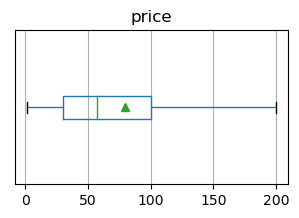

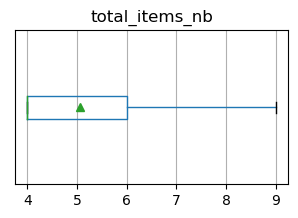

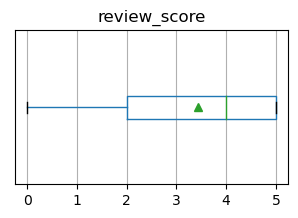

--------------------------------------------------
Cluster 2 :


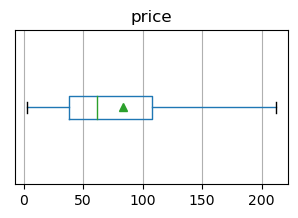

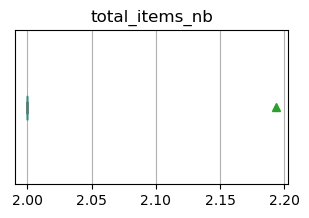

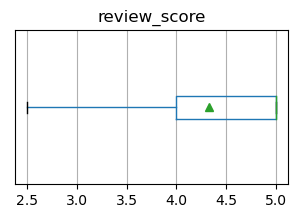

--------------------------------------------------
Cluster 4 :


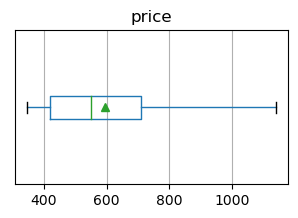

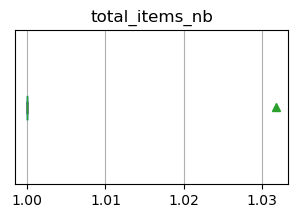

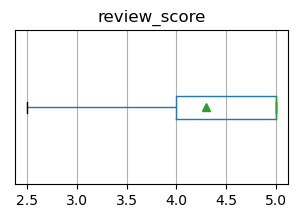

--------------------------------------------------
Cluster 3 :


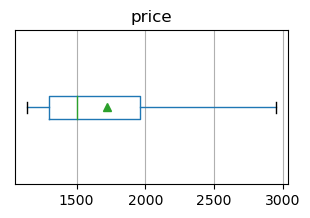

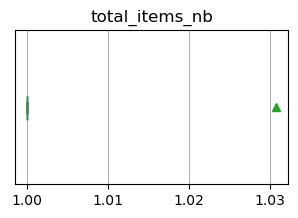

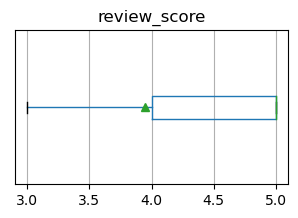

--------------------------------------------------


<IPython.core.display.Javascript object>

In [48]:
# Features distribution by cluster - boxplot
for c in X["cluster"].unique():
    print("Cluster", c, ":")
    for i in range(len(col_std)):
        fig = plt.figure(figsize=(12, 2))
        fig.add_subplot(1, len(col_std), i + 1)
        feat = col_std[i]
        X[X["cluster"] == c].boxplot(
            column=feat, vert=False, showfliers=False, showmeans=True
        )
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        plt.title(feat)
        i = +1
        plt.show()
    print(50 * "-")